 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [2]:

import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer,RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss,  classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt
import time
from category_encoders.binary import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [136]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [173]:
vc = df.made_donation_in_march_2007.value_counts()
accuracy_score_ = vc[0]/len(df)
accuracy_score_


0.76203208556149737

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

True Positive/Actual Yes = 1 for baseline

## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [6]:
tc = 'made_donation_in_march_2007'
X = df.drop(tc,axis=1)
y = df[tc]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y.head()

((561, 4), (187, 4), (561,), (187,), 0    1
 1    1
 2    1
 3    1
 4    0
 Name: made_donation_in_march_2007, dtype: int64)

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [139]:
pipe = make_pipeline(
        StandardScaler(), 
        SelectKBest(f_classif),
        LogisticRegression())

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [200]:
param_grid = {
    'selectkbest__k': [1,2,3,4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=True)

search.fit(X, y)
y.head()

0    1
1    1
2    1
3    1
4    0
Name: made_donation_in_march_2007, dtype: int64

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [141]:
print('Best Parameter (CV score=%0.5f):' % search.best_score_)
print(search.best_params_)

Best Parameter (CV score=0.78479):
{'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'selectkbest__k': 4}


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [218]:
accuracy = (36 + 85) / (85 + 58 + 8 + 36)
accuracy

0.6470588235294118

Calculate precision

In [143]:
precision = 36 / (36 + 58)
precision

0.3829787234042553

Calculate recall

In [144]:
recall = 36 / (8 + 36)
recall

0.8181818181818182

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

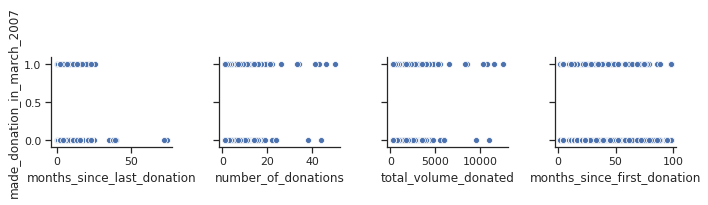

In [7]:
sns.set(style='ticks', color_codes=True)
independant_columns = df.columns.drop(tc)
sns.pairplot(data=df,
                  y_vars=[tc],
                  x_vars=independant_columns);

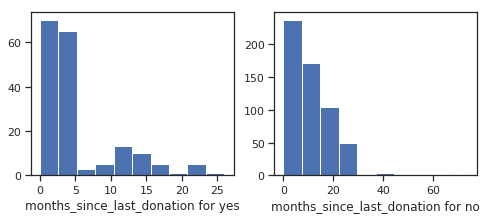

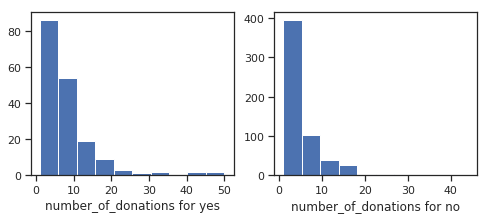

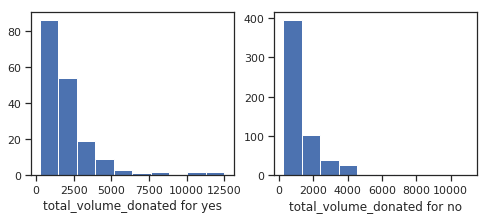

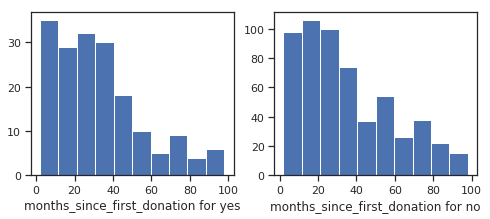

In [25]:
for c in independant_columns:
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(8, 3)
    axs[0].hist(df[df[tc] == 1][c])
    axs[1].hist(df[df[tc] == 0][c])
    axs[0].set_xlabel(f'{c} for yes')
    axs[1].set_xlabel(f"{c} for no")
    plt.show()

In [145]:
param_grid = {
    'selectkbest__k': [4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': np.linspace(.001, .1, 20)
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)

search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7ffb0927fc80>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'selectkbest__k': [4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': array([ 0.001  ,  0.00621,  0.01142,  0.01663,  0.02184,  0.02705,
        0.03226,  0.03747,  0.04268,  0.04789,  0.05311,  0.05832,
        0.06353,  0.06874,  0.07395,  0.07916,  0.08437,  0.08958,
        0.09479,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [146]:
print('Best Parameter (CV score=%0.5f):' % search.best_score_)
print(search.best_params_)

Best Parameter (CV score=0.78745):
{'logisticregression__C': 0.094789473684210521, 'logisticregression__class_weight': None, 'selectkbest__k': 4}


In [148]:
# Best Parameter (CV score=0.78745):df.head()

In [149]:
df.months_since_last_donation.unique()

array([ 2,  0,  1,  4,  5,  9,  3, 12,  6, 11, 10, 13,  8, 14,  7, 16, 15,
       23, 21, 18, 22, 26, 35, 38, 40, 74, 20, 17, 25, 39, 72])

In [150]:
# df['last_5_months'] = df.months_since_last_donation < 6

In [151]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [201]:
# X = df.drop([tc,'months_since_last_donation'],axis=1)
X = df.drop(tc, axis=1)
y = df[tc]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y.head()

((561, 4), (187, 4), (561,), (187,), 0    1
 1    1
 2    1
 3    1
 4    0
 Name: made_donation_in_march_2007, dtype: int64)

In [153]:
X.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


In [154]:
X.iloc[:,2][0:5]

0    12500
1     3250
2     4000
3     5000
4     6000
Name: total_volume_donated, dtype: int64

In [155]:
# class_weight = {0: 1, 1: 10}
#class_weight = {0: {0: 1, 1:.1, 2:.1}, 1: 1 }
class_weight = {0: 1, 1:1}
logistic = LogisticRegression(solver = 'liblinear', class_weight = class_weight, random_state=42 )
# f = logistic.fit(X,y)
pipe = make_pipeline(
        StandardScaler(), 
        SelectKBest(f_classif),
        logistic)

In [156]:
# class_weight[2]

In [202]:

param_grid = {
    'selectkbest__k': [3,4],
     'logisticregression__class_weight':  [None,'balanced'],
    'logisticregression__C': np.linspace(.001, .1, 20)
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)

search.fit(X, y)
print('Best Parameter (CV score=%0.5f):' % search.best_score_)
print(search.best_params_)
y.head()
# Best Parameter (CV score=0.78745):

Best Parameter (CV score=0.78745):
{'logisticregression__C': 0.094789473684210521, 'logisticregression__class_weight': None, 'selectkbest__k': 4}


0    1
1    1
2    1
3    1
4    0
Name: made_donation_in_march_2007, dtype: int64

In [158]:
# encoders = Pipeline([
#                 ('binary', BinaryEncoder(cols=['nameDest'])),
#                 ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=['type']))
#             ])
# df_ = encoders.fit_transform(df)
# df_.head()


In [186]:
import sklearn.feature_selection as fe

MIR = fe.SelectKBest(fe.mutual_info_regression, k='all').fit(X, y)
names = X.columns.tolist()
MIR_scores = pd.Series(data=MIR.scores_, name='MI_Reg_Scores', index=names)

MIR_scores

/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


months_since_last_donation     0.010944
number_of_donations            0.027137
total_volume_donated           0.015011
months_since_first_donation    0.006683
Name: MI_Reg_Scores, dtype: float64

In [203]:
X = df.drop(tc,axis=1)
y = df[tc]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y.head()

((561, 4), (187, 4), (561,), (187,), 0    1
 1    1
 2    1
 3    1
 4    0
 Name: made_donation_in_march_2007, dtype: int64)

In [179]:
pipe = make_pipeline(
        StandardScaler(), 
        SelectKBest(f_classif),
        LogisticRegression())

In [187]:

param_grid = {
    'selectkbest__k': [3,4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': np.linspace(.001, .1, 20),
    'logisticregression__random_state': [42],

}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=True)

search.fit(X, y)
print('Best Parameter (CV score=%0.5f):' % search.best_score_)
print(search.best_params_)

Best Parameter (CV score=0.78745):
{'logisticregression__C': 0.094789473684210521, 'logisticregression__class_weight': None, 'logisticregression__random_state': 42, 'selectkbest__k': 4}


In [188]:
y_pred = search.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.24598930481283424

In [174]:
accuracy_score(y_test, y_pred)

0.75401069518716579

In [191]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.98      0.86       139
          1       0.62      0.10      0.18        48

avg / total       0.73      0.75      0.68       187



In [194]:
y_pred_df = pd.DataFrame(y_pred, columns=['v'])
y_pred_df.head()

,v
0,0
1,0
2,0
3,0
4,0


In [207]:
y_df = y_pred_df.join(y_test, y_test.index)

In [209]:
y_df.head()

,v,made_donation_in_march_2007
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [211]:
y_df[(y_df.v == 0) & (y_df.made_donation_in_march_2007 == 1)].shape   # False Positive Rate: When it's actually no, how often does it predict yes?

(43, 2)

In [212]:
y_df.shape

(187, 2)

In [213]:
y_df[y_df.v == 0].shape 

(179, 2)

In [215]:
false_positive = 43 / 179
false_positive

0.24022346368715083